## Linear SVM

In [1]:
import helpers as helpers
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

from sklearn.metrics import *

from sklearn.model_selection import GridSearchCV, learning_curve
from scipy.special import expit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import csv

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
MODEL_NAME = "linear"
DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"

In [3]:
data, labels = helpers.get_data(datapath=DEPRESSION_PATH, tokenize=False, by_character=False)

train_text, dev_text, test_text = helpers.split(data=data, dist=TDT_SPLIT)
train_dep, dev_dep, test_dep = helpers.split(data=labels, dist=TDT_SPLIT)

# Handles tokenization internally
model = CountVectorizer(max_features=50_000, ngram_range=(1,2), min_df=2)
model.fit(train_text)
train_vectors = model.transform(train_text)
dev_vectors = model.transform(dev_text)
test_vectors = model.transform(test_text)

# SVC expects normalized data, but it has a negligible effect
scaler = Normalizer(norm='l2')
scaler.fit(train_vectors)
train_vectors = scaler.transform(train_vectors)
dev_vectors = scaler.transform(dev_vectors)
test_vectors = scaler.transform(test_vectors)

Completing 80/10/10 split
Completing 80/10/10 split


In [4]:
# print(train_vectors.shape)
# total = 0
# for row in train_vectors:
#     total += sum(row.toarray())
# print(sum(total))

In [5]:
estimator = LinearSVC()

param_grid = {
    'penalty': ['l1', 'l2'],
    'tol': [.000005, .00001, .00005, .0001],
    'C': [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator, param_grid, scoring='f1', n_jobs=-1)


In [6]:
grid_search.fit(train_vectors, train_dep)

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/sit

,estimator,LinearSVC()
,param_grid,"{'C': [0.1, 1, ...], 'penalty': ['l1', 'l2'], 'tol': [5e-06, 1e-05, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [7]:
best_estimator = grid_search.best_estimator_

In [8]:
dev_predictions = best_estimator.predict(dev_vectors)

precision = precision_score(dev_dep, dev_predictions)
recall = recall_score(dev_dep, dev_predictions)
f1 = f1_score(dev_dep, dev_predictions)
accuracy = accuracy_score(dev_dep, dev_predictions)

# Calculate PR-AUC
dev_scores = best_estimator.decision_function(dev_vectors)
dev_probs = expit(dev_scores)
precision_points, recall_points, _ = precision_recall_curve(dev_dep, dev_probs)
pr_auc = auc(recall_points, precision_points)

# Calculate ROC-AUC
auc_score = roc_auc_score(dev_dep, dev_scores)

# save results to csv
csv_file_name = "results/results.csv"
row = [f'{MODEL_NAME}_dev', precision, recall, f1, accuracy, pr_auc, auc_score]
helpers.save_to_csv(csv_file_name, row)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Accuracy: {accuracy}")

Data appended to results/results.csv
Precision: 0.9378378378378378
Recall: 0.8852040816326531
F1: 0.910761154855643
Accuracy: 0.9120310478654593


In [9]:
best_estimator.score(test_vectors, test_dep)

0.9018087855297158

PR-AUC: 0.9687090261347229
AUC Score: 0.964
Data appended to results/results.csv
Plot saved: results/linear/confusion_linear.png


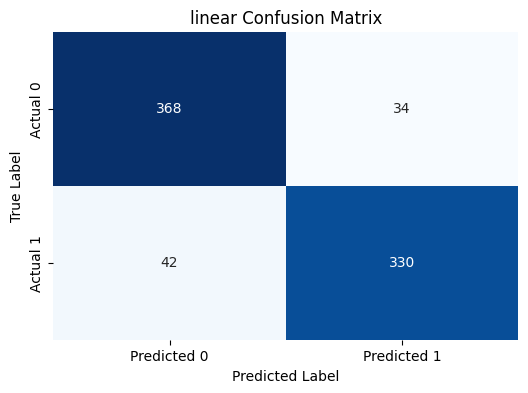

In [10]:
test_scores = best_estimator.decision_function(test_vectors)

# PR-AUC
test_probs = expit(test_scores)
precision_points, recall_points, _ = precision_recall_curve(test_dep, test_probs)
pr_auc = auc(recall_points, precision_points)
print(f"PR-AUC: {pr_auc}")

# ROC-AUC
fpr, tpr, thresholds = roc_curve(test_dep, test_scores)
auc_score = roc_auc_score(test_dep, test_scores)
print(f"AUC Score: {auc_score:.3f}")

# Confusion matrix
test_preds = grid_search.best_estimator_.predict(test_vectors)
cm = confusion_matrix(test_dep, test_preds)

# get test metrics
precision = precision_score(test_dep, test_preds)
recall = recall_score(test_dep, test_preds)
f1 = f1_score(test_dep, test_preds)
accuracy = accuracy_score(test_dep, test_preds)

# save test results to csv
csv_file_name = "results/results.csv"
row = [f'{MODEL_NAME}_test', precision, recall, f1, accuracy, pr_auc, auc_score]
helpers.save_to_csv(csv_file_name, row)

# show cm
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{MODEL_NAME} Confusion Matrix')

# save graph
file_name = f"results/{MODEL_NAME}/confusion_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

Plot saved: results/linear/learning_curve_linear.png


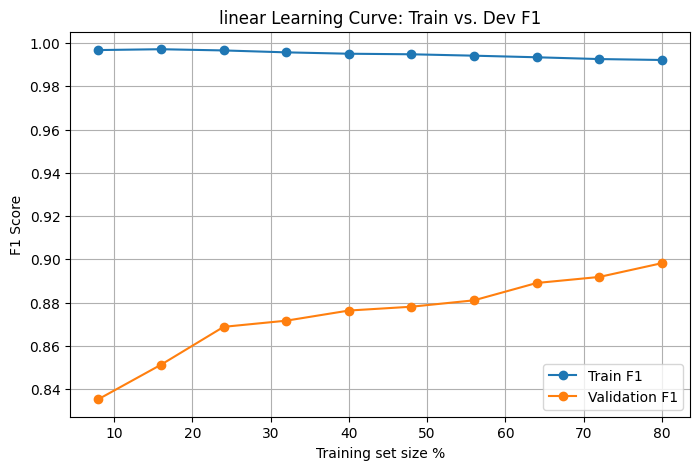

Plot saved: results/linear/pr_linear.png


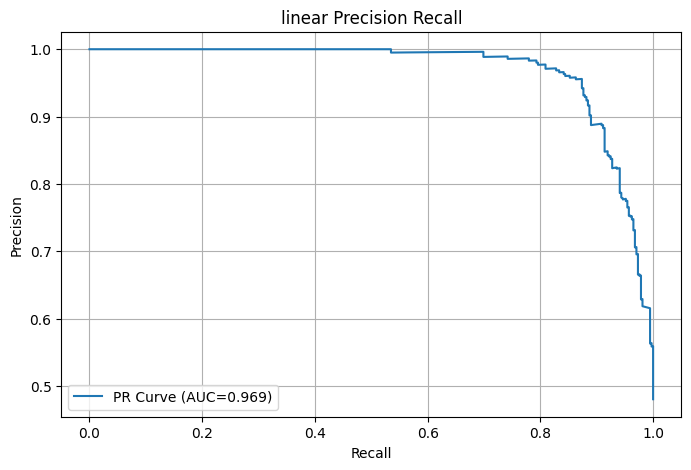

Plot saved: results/linear/roc_linear.png


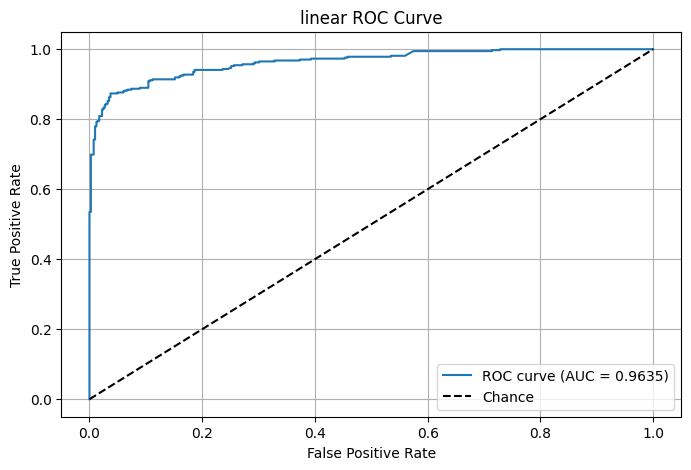

In [11]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_,
    train_vectors,
    train_dep,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes * 100 / train_vectors.shape[0], train_mean, marker='o', label='Train F1')
plt.plot(train_sizes * 100 / train_vectors.shape[0], test_mean, marker='o', label='Validation F1')
plt.xlabel('Training set size %')
plt.ylabel('F1 Score')
plt.title(f'{MODEL_NAME} Learning Curve: Train vs. Dev F1')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/learning_curve_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# PR graph
precision_points, recall_points, _ = precision_recall_curve(test_dep, test_probs)
pr_auc = auc(recall_points, precision_points)

plt.figure(figsize=(8,5))
plt.plot(recall_points, precision_points, label=f'PR Curve (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{MODEL_NAME} Precision Recall')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/pr_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(test_dep, test_probs)
roc_auc = roc_auc_score(test_dep, test_probs)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{MODEL_NAME} ROC Curve')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/roc_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

Plot saved: results/linear/most_linear.png


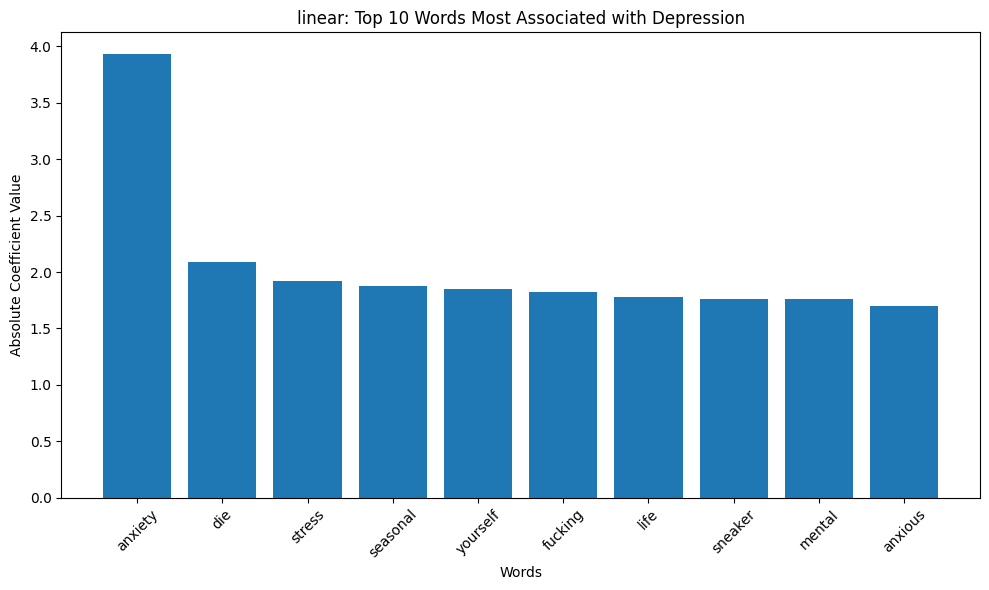

Plot saved: results/linear/least_linear.png


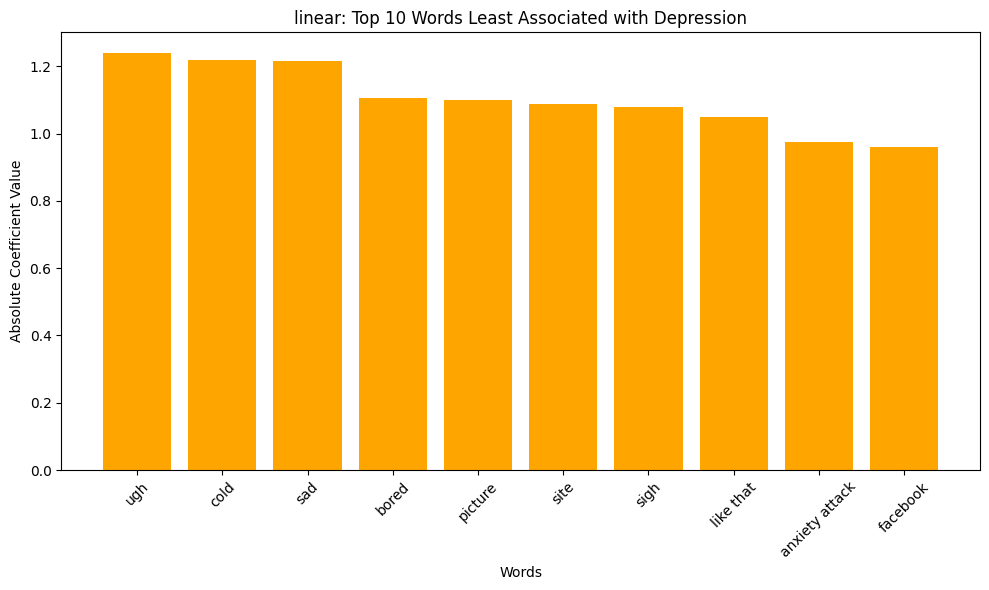

In [12]:
best = grid_search.best_estimator_
feature_names = model.get_feature_names_out()
coefficients = best.coef_[0]

k = 10
sorted_coef = np.sort(coefficients)

# =================================================
# top k words MOST associated with depression
# =================================================

pos_indices = np.argsort(coefficients)[-k:][::-1]
pos_words = feature_names[pos_indices] # top k words MOST associated with depression

plt.figure(figsize=(10,6))
plt.bar(pos_words, coefficients[pos_indices])
plt.xlabel('Words')
plt.ylabel('Absolute Coefficient Value')
plt.title(f'{MODEL_NAME}: Top {k} Words Most Associated with Depression')
plt.xticks(rotation=45)
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/most_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# =================================================
# top k words LEAST associated with depression
# =================================================

neg_indices = np.argsort(coefficients)[:k]
neg_words = feature_names[neg_indices] 

plt.figure(figsize=(10,6))
plt.bar(neg_words, abs(coefficients[neg_indices]), color='orange')
plt.xlabel('Words')
plt.ylabel('Absolute Coefficient Value')
plt.title(f'{MODEL_NAME}: Top {k} Words Least Associated with Depression')
plt.xticks(rotation=45)
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/least_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

## Ablations

=== Class Weighting Ablation ===
No class weighting:
  Accuracy: 0.9120
  F1: 0.9108
  Precision: 0.9378
  Recall: 0.8852
Balanced class weighting:
  Accuracy: 0.9120
  F1: 0.9108
  Precision: 0.9378
  Recall: 0.8852
Plot saved: results/linear/ablation_class_weight_linear.png


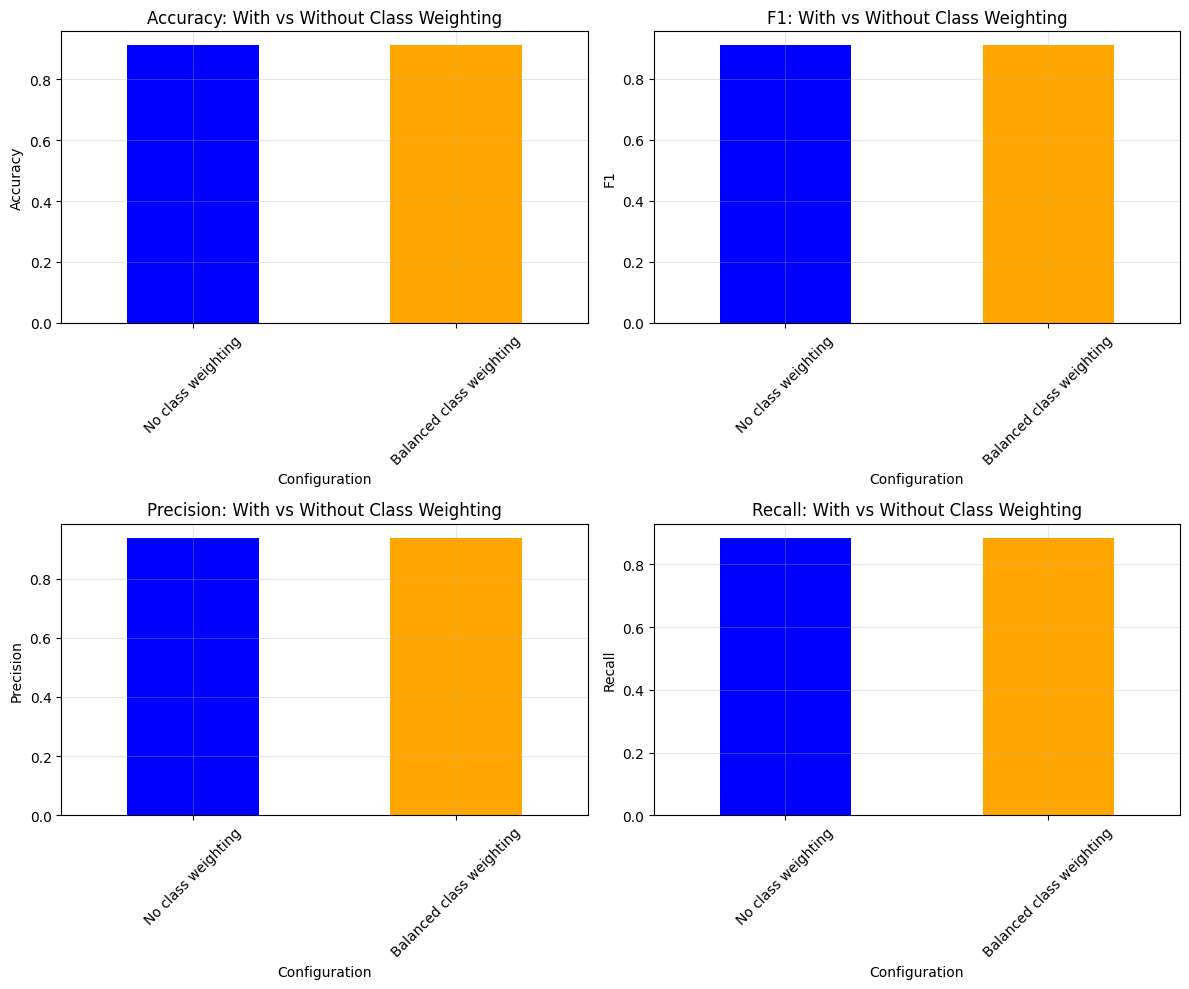

In [13]:
print("=== Class Weighting Ablation ===")

class_weight_results = {}
for weight_config in [None, 'balanced']:
    svm = LinearSVC(C=1.0, class_weight=weight_config, max_iter=2000, random_state=42)
    svm.fit(train_vectors, train_dep)
    dev_predictions = svm.predict(dev_vectors)
    
    weight_name = "No class weighting" if weight_config is None else "Balanced class weighting"
    class_weight_results[weight_name] = {
        'accuracy': accuracy_score(dev_dep, dev_predictions),
        'f1': f1_score(dev_dep, dev_predictions),
        'precision': precision_score(dev_dep, dev_predictions),
        'recall': recall_score(dev_dep, dev_predictions)
    }
    print(f"{weight_name}:")
    print(f"  Accuracy: {class_weight_results[weight_name]['accuracy']:.4f}")
    print(f"  F1: {class_weight_results[weight_name]['f1']:.4f}")
    print(f"  Precision: {class_weight_results[weight_name]['precision']:.4f}")
    print(f"  Recall: {class_weight_results[weight_name]['recall']:.4f}")

weight_df = pd.DataFrame(class_weight_results).T
weight_df = weight_df[['accuracy', 'f1', 'precision', 'recall']]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, metric in enumerate(['accuracy', 'f1', 'precision', 'recall']):
    ax = axes[idx // 2, idx % 2]
    weight_df[metric].plot(kind='bar', ax=ax, color=['blue', 'orange'])
    ax.set_title(f'{metric.capitalize()}: With vs Without Class Weighting')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Configuration')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
file_name = f"results/{MODEL_NAME}/ablation_class_weight_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
plt.show()


=== Threshold Tuning Ablation ===
Optimal threshold (max F1): 0.500
F1 at optimal threshold: 0.9108
Precision: 0.9378
Recall: 0.8852
Default threshold (0.5):
  F1: 0.9108
  Precision: 0.9378
  Recall: 0.8852
Plot saved: results/linear/ablation_threshold_linear.png


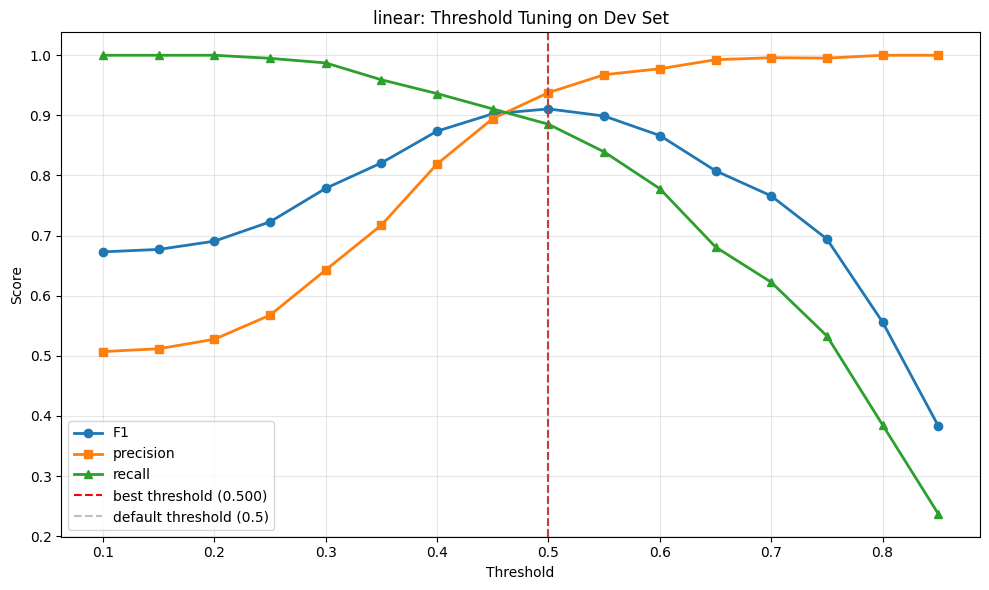

=== Test Set Performance ===
Default threshold (0.5):
  F1: 0.8967
  Precision: 0.9066
  Recall: 0.8871
Optimal threshold (0.500):
  F1: 0.8967
  Precision: 0.9066
  Recall: 0.8871


In [14]:
print("=== Threshold Tuning Ablation ===")

best_model = grid_search.best_estimator_
dev_scores = best_model.decision_function(dev_vectors)
dev_probs = expit(dev_scores)

thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    dev_preds_thresh = (dev_probs >= threshold).astype(int)
    threshold_results.append({
        'threshold': threshold,
        'f1': f1_score(dev_dep, dev_preds_thresh),
        'precision': precision_score(dev_dep, dev_preds_thresh),
        'recall': recall_score(dev_dep, dev_preds_thresh),
        'accuracy': accuracy_score(dev_dep, dev_preds_thresh)
    })

threshold_df = pd.DataFrame(threshold_results)

# maximize f1
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
print(f"Optimal threshold (max F1): {optimal_threshold:.3f}")
print(f"F1 at optimal threshold: {threshold_df.loc[optimal_idx, 'f1']:.4f}")
print(f"Precision: {threshold_df.loc[optimal_idx, 'precision']:.4f}")
print(f"Recall: {threshold_df.loc[optimal_idx, 'recall']:.4f}")

# default (0.5)
default_idx = (threshold_df['threshold'] - 0.5).abs().idxmin()
print(f"Default threshold (0.5):")
print(f"  F1: {threshold_df.loc[default_idx, 'f1']:.4f}")
print(f"  Precision: {threshold_df.loc[default_idx, 'precision']:.4f}")
print(f"  Recall: {threshold_df.loc[default_idx, 'recall']:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['f1'], marker='o', label='F1', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], marker='s', label='precision', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['recall'], marker='^', label='recall', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'best threshold ({optimal_threshold:.3f})')
plt.axvline(x=0.5, color='gray', linestyle='--', label='default threshold (0.5)', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'{MODEL_NAME}: Threshold Tuning on Dev Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/ablation_threshold_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
plt.show()

test_scores = best_model.decision_function(test_vectors)
test_probs = expit(test_scores)
test_preds_optimal = (test_probs >= optimal_threshold).astype(int)
test_preds_default = (test_probs >= 0.5).astype(int)

print("=== Test Set Performance ===")
print(f"Default threshold (0.5):")
print(f"  F1: {f1_score(test_dep, test_preds_default):.4f}")
print(f"  Precision: {precision_score(test_dep, test_preds_default):.4f}")
print(f"  Recall: {recall_score(test_dep, test_preds_default):.4f}")

print(f"Optimal threshold ({optimal_threshold:.3f}):")
print(f"  F1: {f1_score(test_dep, test_preds_optimal):.4f}")
print(f"  Precision: {precision_score(test_dep, test_preds_optimal):.4f}")
print(f"  Recall: {recall_score(test_dep, test_preds_optimal):.4f}")


## Look at Incorrect Cases

In [15]:
best = grid_search.best_estimator_

best_predictions = best.predict(dev_vectors)
false_pos_idx = []
false_neg_idx = []

for i in range(len(best_predictions)):
    curr = best_predictions[i]
    if curr != dev_dep[i]:
        if curr == 1:
            false_pos_idx.append(i)  # predicted 1, actual 0
        else:
            false_neg_idx.append(i)   # predicted 0, actual 1

# for i in false_neg_idx:
#     print(dev_text[i])

# for i in false_pos_idx:
#     print(dev_text[i])